In [1]:
from graph_cnn.model import create_model
from graph_cnn.graph import create_final_graph,cross_over
import networkx as nx
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import clear_output

2024-01-14 14:50:33.839725: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 14:50:33.841859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 14:50:33.870969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 14:50:33.871015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 14:50:33.872128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

DiGraph with 5 nodes and 6 edges


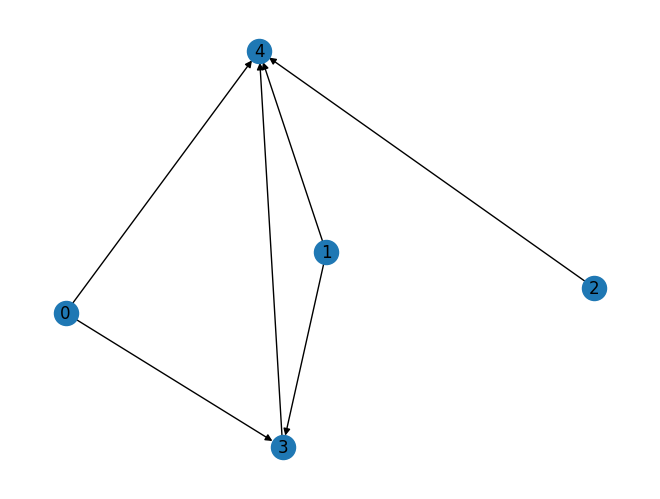

32
(None, 28, 28, 32)
Tensor("Placeholder:0", shape=(None, 28, 28, 32), dtype=float32)
(None, 28, 28, 32)
Tensor("Placeholder:0", shape=(None, 28, 28, 32), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           64        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 32)           64        ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)    

In [2]:
graph_ = create_final_graph(5,0.7)
print(graph_)
nx.draw(graph_,with_labels=True)
plt.show()
model = create_model(graph_,input_shape=(28,28,1),num_classes=10)
model.summary()

In [3]:
train_dataset, info = tfds.load('mnist', split='train', with_info=True, as_supervised=True, shuffle_files=True)
test_dataset = tfds.load('mnist', split='test', as_supervised=True, shuffle_files=True)

# Print dataset information
print(info)

train_dataset = train_dataset.cache().shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
for i,j in train_dataset:
    print(i)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/balasai/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)
tf.Ten

In [4]:
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
#random_flip = tf.keras.layers.RandomFlip("horizontal")(input_layer)
#random_rotation = tf.keras.layers.RandomRotation(0.2)(random_flip)
#random_zoom = tf.keras.layers.RandomZoom(0.2)(random_rotation)
#gaussian_noise = tf.keras.layers.GaussianNoise(0.3)(random_zoom)
rescaling = tf.keras.layers.Rescaling(1./255)(input_layer)
output = model(rescaling)

model2 = tf.keras.models.Model(inputs=input_layer, outputs=output)


Tensor("model/dropout_6/Identity:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("model/dropout_5/Identity:0", shape=(None, 28, 28, 32), dtype=float32)


In [5]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.FalseNegatives(name='fn'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [6]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=METRICS)
model2.summary()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,min_delta=0.01, min_lr=0)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        y_pred =  np.array(self.model.predict(test_dataset))[0]
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
        cm = confusion_matrix(true_labels, predicted_labels)
        print(cm)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 model (Functional)          [(None, 10),              876515    
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
Total params: 876515 (3.34 MB)
Trainable params: 876259 (3.34 MB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________


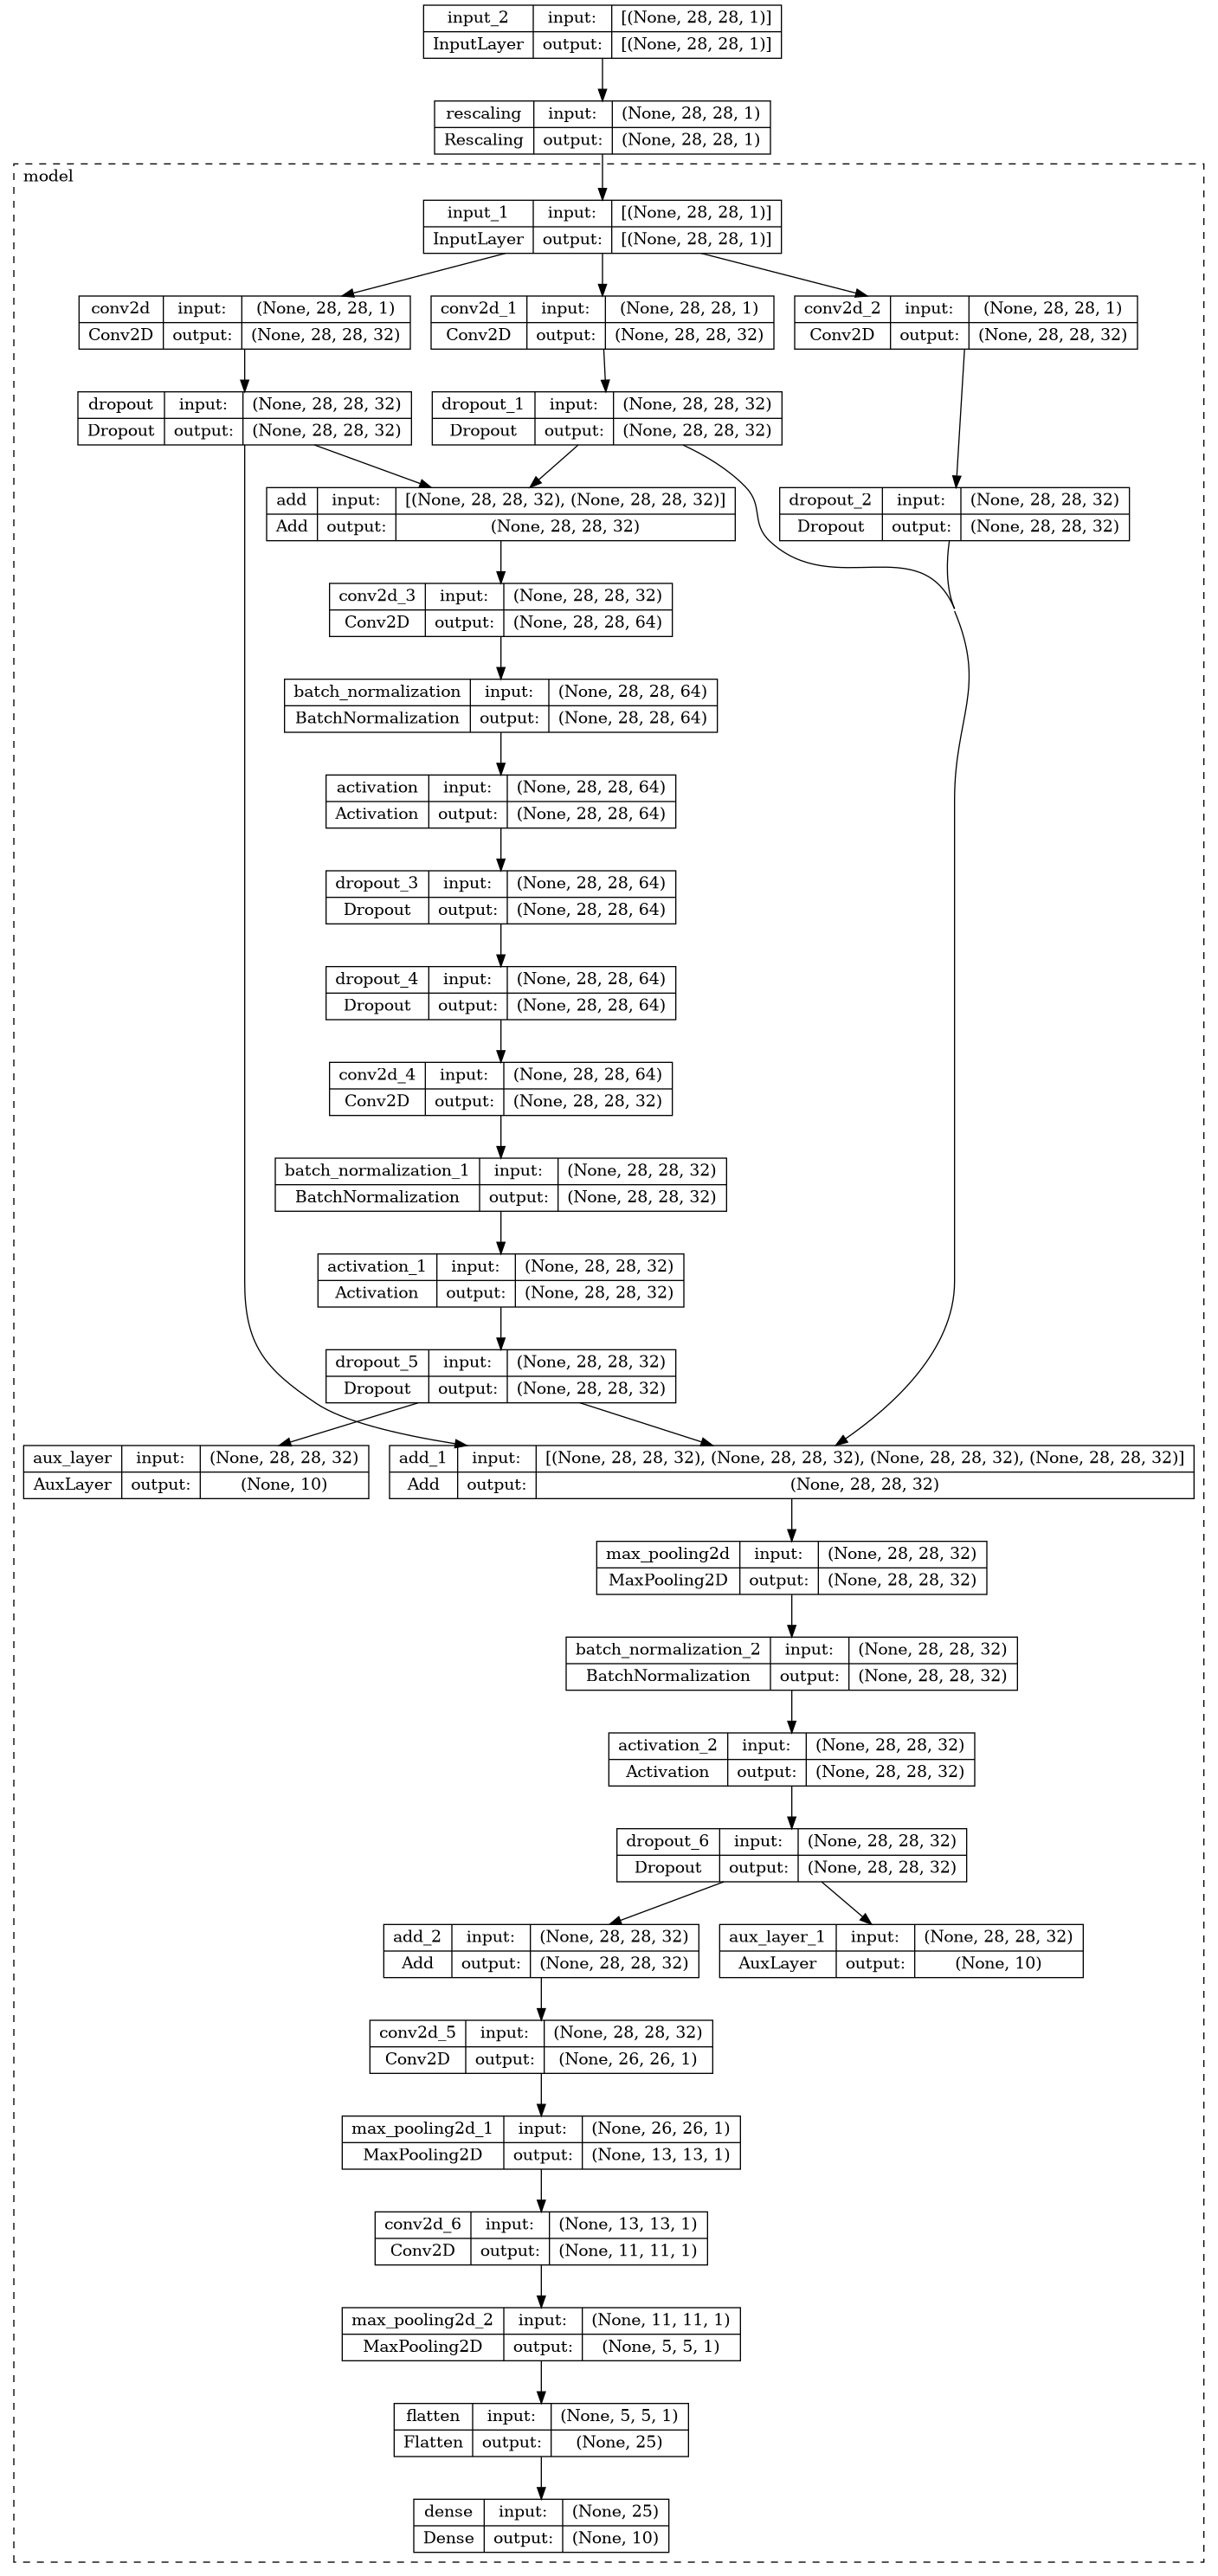

In [7]:
tf.keras.utils.plot_model(model2, to_file="model.png", show_shapes=True, show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)

In [8]:
'''model2=tf.keras.applications.densenet.DenseNet121(include_top=False, weights=None, input_shape=(36,36,3), pooling=None, classes=10)
model = tf.keras.models.Sequential([
    model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()'''

"model2=tf.keras.applications.densenet.DenseNet121(include_top=False, weights=None, input_shape=(36,36,3), pooling=None, classes=10)\nmodel = tf.keras.models.Sequential([\n    model2,\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(10, activation='softmax'),\n])\n\nmodel.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])\nmodel.summary()"

In [9]:
# Predict on the test dataset
predictions = model2.predict(test_dataset)
predictions = np.array(predictions)[0]
# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
print(true_labels,predicted_labels.shape)
print(true_labels.shape,predicted_labels.shape)

# Plot the classification results
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print(cm)

Tensor("model_1/model/dropout_6/Identity:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("model_1/model/dropout_5/Identity:0", shape=(None, 28, 28, 32), dtype=float32)
79/79 [==============================] - 10s 124ms/step
[5 0 7 ... 1 4 6] (10000,)
(10000,) (10000,)
[[710  32   2   0   8 220   1   7   0   0]
 [816  49   1   0   7 248   0  13   1   0]
 [773  37   1   0   8 202   1  10   0   0]
 [735  40   5   0   9 215   0   6   0   0]
 [696  42   3   0   5 226   0  10   0   0]
 [649  36   2   0   7 184   2  12   0   0]
 [670  35   3   0   5 234   1  10   0   0]
 [749  34   3   0   7 219   2  13   1   0]
 [699  36   2   0   7 226   0   4   0   0]
 [737  42   3   0  12 209   1   5   0   0]]


In [10]:
model2.fit(train_dataset, epochs=100, validation_data=test_dataset,callbacks=[reduce_lr,early_stop,DisplayCallback()])

Epoch 1/100
Tensor("model_1/model/dropout_6/dropout/SelectV2:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("model_1/model/dropout_5/dropout/SelectV2:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("model_1/model/dropout_6/dropout/SelectV2:0", shape=(None, 28, 28, 32), dtype=float32)
Tensor("model_1/model/dropout_5/dropout/SelectV2:0", shape=(None, 28, 28, 32), dtype=float32)
261/469 [===============>..............] - ETA: 1:41 - loss: 11.2693 - model_loss: 6.5071 - model_1_loss: 2.3614 - model_2_loss: 2.4007 - model_accuracy: 0.0000e+00 - model_1_accuracy: 0.0793 - model_2_accuracy: 0.0903